Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


[[9.62409]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 9.6241
Epoch 2/1000
[[9.52582]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5258
Epoch 3/1000
[[9.43076801]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.4308
Epoch 4/1000
[[9.33900261]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3390
Epoch 5/1000
[[9.25056553]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.2506
Epoch 6/1000
[[9.16549301]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.1655
Epoch 7/1000
[[9.08381271]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.0838
Epoch 8/1000
[[9.00554466]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0055
Epoch 9/1000
[[8.93070507]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.9307
Epoch 10/1000
[[8.85930061]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.8593
Epoch 11/1000
[[8.79133129]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.7913
Epoch 12/1000
[[8.72678375]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.7268
Epoch 13/1000
[[8.66564274]]
1/1 ━━━━━━━━━━━━━

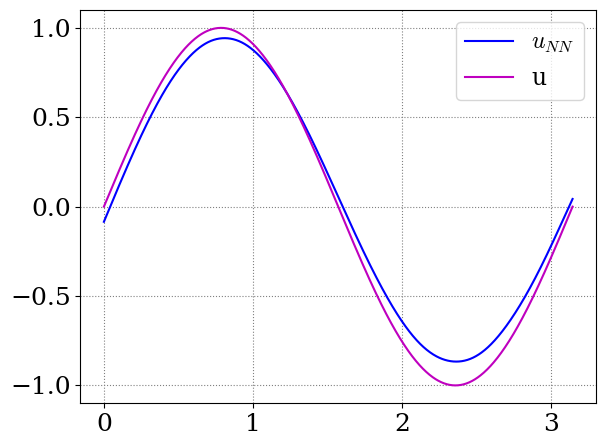

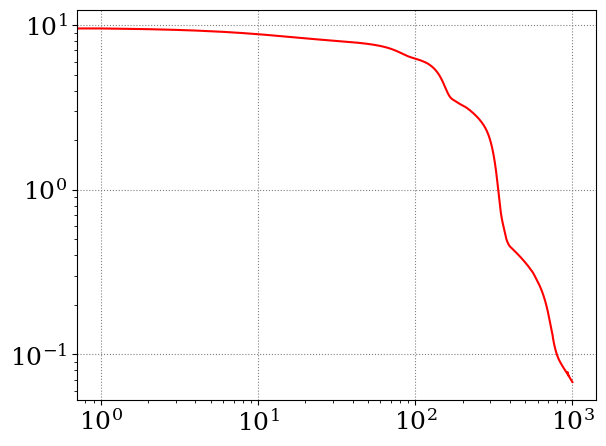

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Define the number of neuron per layer
NN = 10
#Define the number of layers 
NL = 5
#Define number of collocation points
N_points = 100
#Define the source
def f_source(x):
    return -4*tf.sin(2*x)
def uexact(x):
    return tf.sin(2*x)


#Input dummy
X = tf.keras.layers.Input(shape = (1,))

#Define the first layer with dummy input
L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(X)

#Feed the first layer to a generic layer for the number of layers, withoput the first and last layers
for l in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation = 'tanh')(L1)

#Last larey after being fed with the second to last layer (1 output)
LO = tf.keras.layers.Dense(units=1, activation = 'tanh')(L1)

#Assembly the model
U_model = tf.keras.Model(inputs = X, outputs = LO, name = 'U_model')
#model summary
U_model.summary()


#Define a class for the loss, we are going to call this class in every iteration, evaluating this on the randomized sample, the target function and the output of the network
class loss(tf.keras.layers.Layer):

    def __init__(self, U_model, N_points,f_source, **kwargs):
        super(loss,self).__init__()
        self.U_model = U_model
        self.N_points = N_points
        self.f_source = f_source
    
    def  call(self,inputs):
        S = tf.experimental.numpy.linspace(0.,np.pi,num=self.N_points, dtype='float32')
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(S)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(S)
                ueval = U_model(S)
                u_x = t2.gradient(ueval,S)
            u_xx = t1.gradient(u_x,S)   
    

        f_source = self.f_source(S)
        loss_out = tf.math.reduce_mean((u_xx - f_source)**2) + self.U_model(np.array([0.]))**2 + self.U_model(np.array([np.pi]))**2 
        tf.print(loss_out)
        return loss_out    

#Tell tensorlofw to recognize this class as a loss
def loss_model(U_model,N_points, f_source):
    Xl = tf.keras.layers.Input(shape = (1,))
    loss_layer = loss(U_model, N_points, f_source)(Xl)
    loss_f = tf.keras.Model(inputs = Xl, outputs = loss_layer)
    return loss_f


def loss_value(x,y):
    return y

model_all = loss_model(U_model, N_points, f_source)
optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-3)
model_all.compile(optimizer = optimizer, loss = loss_value)

history = model_all.fit(np.array([1.]),np.array([1.]),epochs = 1000)


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19


# Generate a list of x values for visualization
#xlist = np.array([np.pi/1000 * i for i in range(1000)])

xlist = tf.experimental.numpy.linspace(0.,np.pi,num=1000, dtype='float32')

## ---------
# SOLUTION
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(xlist, U_model(xlist), color='b')
plt.plot(xlist, uexact(xlist), color='m')

plt.legend(['$u_{NN}$', 'u'])

ax.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()
Loss_rel = history.history['loss'] #/1.5707963267948972
fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(Loss_rel, color='r')


ax.set_xscale('log')
ax.set_yscale('log')



ax.grid(which = 'major', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()


